# Latar Belakang

Youtube ialah sebuah situs web yang dirancang untuk berbagi video. Dengan adanya Youtube, seorang konten kreator bisa memposting video sehingga dapat dilihat dan diapresiasi oleh banyak orang. Ada berbagai macam kategori video yang diunggah mulai dari entertainment, music, tutorial, comedy, sports, dll. Namun, banyaknya konten kreator Youtube akan memicu persaingan yang ketat, terutama Youtube memiliki fitur yang bernama youtube trending. Trending bertujuan untuk menampilkan video yang menarik bagi banyak penonton. Hal ini menyebabkan advertiser tertarik untuk menaruh iklan pada video-video Youtube apalagi jika video tersebut trending, maka target yang dapat dijangkau jika menaruh iklan di video tersebut akan semakin luas.

Pada notebook ini, akan dipaparkan analisis untuk mendapatkan wawasan tentang video yang sedang tren di Youtube. Wawasan ini akan digunakan oleh klien untuk bisnis mereka. Disini kita akan menggunakan Python dengan beberapa paket seperti Pandas dan Matplotlib untuk menganalisis data yang bersumber dari catatan harian dari top trending Youtube video (Sumber: Kaggle). 

# Pernyataan Masalah 

Klien ialah seorang advertiser yang ingin mengetahui video yang tepat bagi mereka untuk menempatkan iklan sebelum video-video tersebut menjadi trending.

Pertanyaan: 
* Kategori apa yang paling sering trending?
* Video yang paling banyak bertahan di daftar video trending?
* Channel Youtube apa yang memiliki views paling banyak?
* Apakah tags yang paling sering digunakan pada video trending?
* Berapa persen video trending yang berisi kata dengan full huruf kapital di judulnya?
* Berapa jumlah karakter dari judul video? Berapa jumlah karakter terbaik untuk judul video?
* Apakah kata yang paling sering digunakan pada judul video trending?
* Bagaimana views, likes, dislikes, comment_count, and other berkorelasi satu sama lain? 
* Kapan waktu terbaik untuk mempublish video youtube?

**Bagaimana karakteristik dari video dapat trending?**

Untuk menjawab pertanyaan tersebut, disini sebagai seorang *data analyst*, kita akan melakukan analisis terhadap dataset untuk mendapatkan suatu kesimpulan atau wawasan yang berguna bagi klien. 

# Data

Untuk menjawab pertanyaan di atas, kita akan menganalisa data yang bersumber dari catatan harian top trending Youtube video. Dataset dapat diakses [di sini](https://www.kaggle.com/datasets/rsrishav/youtube-trending-video-dataset?select=US_youtube_trending_data.csv). 

### Import Library

Import beberapa Python package yang akan membantu kita menganalisa data terutama pandas untuk data analysis dan matplotlib untuk visualisasi

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import wordcloud
from collections import Counter

from pandas.io.json import json_normalize
%matplotlib inline

### Read DataFrame

In [2]:
# Read DataFrame Json dan menyimpan dalam variable
with open('US_category_id.json') as data_file:
    data = json.load(data_file)
data

df_json = pd.json_normalize(data, record_path =['items'])

# Read DataFrame csv dan menyimpan dalam variable
df_csv = pd.read_csv('USvideos.csv')

# Menampilkan 5 teratas dari dataframe json dan csv
display(df_json.head(1),df_csv.head(1))

,kind,etag,id,snippet.channelId,snippet.title,snippet.assignable
0,youtube#videoCategory,"""m2yskBQFythfE4irbTIeOgYYfBU/Xy1mB4_yLrHy_BmKm...",1,UCBR8-60-B28hp2BmDPdntcQ,Film & Animation,True


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...


## Data Understanding dan Cleaning

Sebelum masuk ke dalam analisis, kita perlu mengenal dataset kita lebih jauh dalam tahapan *data understanding*. Dari proses ini, kita akan tahu anomali-anomali apa saja yang terdapat di dalam dataset kita dan perlu ditangani dalam tahapan *data cleaning*. 

### DataFrame

Pada dataframe csv terdapat kolom category_id, dimana kolom category_id merepresentasikan kategori dari video youtube tersebut. Keterangan untuk kategori tersebut dapat dilihat pada dataset json. Dengan mencocokkan kolom category_id pada dataset csv dengan kolom id pada dataset json akan didapatkan keterangan kategori untuk video tersebut. Sehingga disini saya akan menggabungkan kedua dataset ini menjadi satu dataframe.

In [3]:
# converting kolom id to numeric type to apply the join
df_json['id'] = df_json['id'].astype(int)

# karna tipe data 'id' masih dalam string, 
# sebelum menggabungkan dataframe Json dan csv, 
# tipe data 'id' diubah menjadi integer terlebih dahulu,
# agar data dapat digabungkan

In [4]:
# Menggabungkan DataFrame Json dan csv menjadi satu dataframe dan menyimpan dalam variable df
df = pd.merge(left=df_csv, right=df_json, left_on='category_id', right_on='id', how='left').drop(columns=['kind','etag','snippet.channelId','id','snippet.assignable'])
pd.set_option('display.max_columns',None)
df.head(1)

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,snippet.title
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...,People & Blogs


### Content:

Dataset ini berisi informasi terkait konten dan fitur dari trending video Youtube (US). Kolom pada dataset ini terdiri dari:
- video_id : kode unik yang biasa terdapat setelah link youtube 
- trending_date: kapan video tersebut menjadi trending
- title: judul dari video yang diunggah di youtube
- channel title: nama channel dari pengunggah video di youtube
- category_id: kategori dari video yang paling sering dicari di youtube
- publish_time: kapan video tersebut diunggah ke youtube
- tags: kata kunci deskriptif untuk membantu penonton menemukan video tersebut
- views: jumlah orang yang telah menonton video tersebut
- likes: jumlah orang yang menyukai video tersebut
- dislikes: jumlah orang yang tidak menyukai video tersebut
- comment_count: jumlah komen yang diberikan penonton pada video tersebut
- thumbnail_link: link untuk cover video tersebut
- comments_disabled: keterangan apakah penonton video tersebut dapat memberikan komentar atau tidak
- ratings_disabled: keterangan apakah penonton dapat melihat rating dari video tersebut atau tidak
- video_error_or_removed: keterangan apakah video dihapus atau tidak
- description: deskripsi yang diberikan oleh pengunggah video terkait isi video
- snippet.title: kategori dari video tersebut


In [5]:
# Informasi dasar mengenai data
print(f'Jumlah baris dan kolom di dataset df adalah {df.shape}')
df.info()

Jumlah baris dan kolom di dataset df adalah (40949, 17)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 40949 entries, 0 to 40948
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   video_id                40949 non-null  object
 1   trending_date           40949 non-null  object
 2   title                   40949 non-null  object
 3   channel_title           40949 non-null  object
 4   category_id             40949 non-null  int64 
 5   publish_time            40949 non-null  object
 6   tags                    40949 non-null  object
 7   views                   40949 non-null  int64 
 8   likes                   40949 non-null  int64 
 9   dislikes                40949 non-null  int64 
 10  comment_count           40949 non-null  int64 
 11  thumbnail_link          40949 non-null  object
 12  comments_disabled       40949 non-null  bool  
 13  ratings_disabled        40949 non-null  bool  
 14

In [6]:
## mengecek data unique ditiap kolom
pd.set_option('display.max_colwidth', None)
list1 = []
for col in df.columns :
    list1.append([col, df[col].nunique(), df.sort_values(col)[col].unique()])

tabel_unique = pd.DataFrame(columns=['Nama Kolum', 'Jumlah Data Unique', 'Unique Sample'],
                     data=list1)
tabel_unique

Nama Kolum  Jumlah Data Unique  \
0                 video_id                6351   
1            trending_date                 205   
2                    title                6455   
3            channel_title                2207   
4              category_id                  16   
5             publish_time                6269   
6                     tags                6055   
7                    views               40478   
8                    likes               29850   
9                 dislikes                8516   
10           comment_count               13773   
11          thumbnail_link                6352   
12       comments_disabled                   2   
13        ratings_disabled                   2   
14  video_error_or_removed                   2   
15             description                6901   
16           snippet.title                  16   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           

Secara umum, kita bisa melihat bahwa:
* dataset ini memiliki 17 kolom dan 40.949 baris
* Semua kolom sudah terisi full kecuali kolom `description` memiliki data kosong. Data kosong pada kolom tersebut diwakili dengan data NaN.
* kolom `thumbnail_link` berisikan link untuk tiap cover video, sehingga tidak relevan dalam analisis dan dihapus saja.

In [7]:
# Mengurutkan kolom DataFrame sesuai keinginan saya
df = df[['category_id','snippet.title','channel_title','video_id','title','trending_date','publish_time','views','likes','dislikes','comment_count','comments_disabled','ratings_disabled','tags','video_error_or_removed','description']]

In [8]:
# Rename kolom snippet.title menjadi category
df = df.rename(columns={'snippet.title':'category'})

In [9]:
# jumlah missing value yang terdapat pada dataset
df.isna().sum()

category_id                 0
category                    0
channel_title               0
video_id                    0
title                       0
trending_date               0
publish_time                0
views                       0
likes                       0
dislikes                    0
comment_count               0
comments_disabled           0
ratings_disabled            0
tags                        0
video_error_or_removed      0
description               570
dtype: int64

In [10]:
# presentasi dari missing value yang terdapat pada dataset 
df.isna().sum()/df.shape[0]*100

category_id               0.000000
category                  0.000000
channel_title             0.000000
video_id                  0.000000
title                     0.000000
trending_date             0.000000
publish_time              0.000000
views                     0.000000
likes                     0.000000
dislikes                  0.000000
comment_count             0.000000
comments_disabled         0.000000
ratings_disabled          0.000000
tags                      0.000000
video_error_or_removed    0.000000
description               1.391975
dtype: float64

<AxesSubplot:>

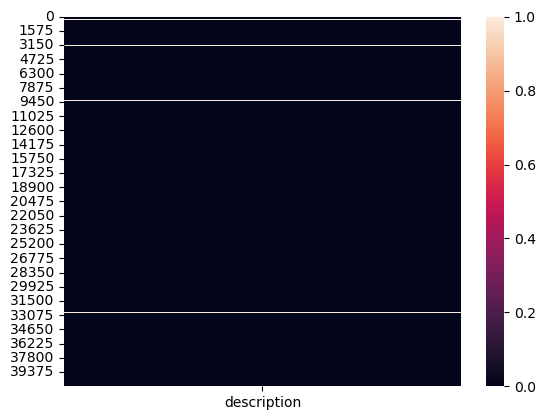

In [11]:
# Sebaran missing value di dalam data
sns.heatmap(df[['description']].isna())

Secara garis besar:  
* *Missing value* di kolom `description` memiliki proporsi yang terhitung kecil, dengan missing value di kolom `description` hanya 1.39%.  

Ada 2 cara untuk menangani *missing value*:
* Pertama, menghapus baris/kolom yang berisi *missing value*. Cara ini tidak disarankan dalam kasus kita, karena hal ini bisa dianalisa lebih lanjut.
* Kedua, mengisi data yang hilang. Cara ini lebih disarankan. Ada beberapa metode yang bisa digunakan untuk mengisi missing value, cara yang paling baik adalah dengan mengisi data yang hilang dengan nilai sebenarnya, atau sedekat mungkin dengan nilai asli. Dalam kasus ini, kita akan mencoba mengisi *missing value* dengan *no description*.

In [12]:
# index data kosong di kolom description 
index_kos_desc = df[df['description'].isna()].index
index_kos_desc

Int64Index([   42,    47,   175,   267,   312,   446,   523,   632,   678,
              750,
            ...
            39506, 39543, 39709, 39744, 39916, 40125, 40325, 40538, 40739,
            40945],
           dtype='int64', length=570)

In [13]:
# Membuat kolom description baru yang hanya berisi keterangan with description and without description 
df.insert(15,'Description_1','With Description')

In [14]:
for i in index_kos_desc:
    df['Description_1'][i] = 'No Description'

C:\Users\user\AppData\Local\Temp\ipykernel_10748\3134683245.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Description_1'][i] = 'No Description'


In [15]:
# Mengisi kolom description yang kosong
df['description'] = df['description'].fillna('No description')

In [16]:
# jumlah missing value yang terdapat pada dataset 
df.isna().sum()

# sudah tidak ada file kosong pada kolom description

category_id               0
category                  0
channel_title             0
video_id                  0
title                     0
trending_date             0
publish_time              0
views                     0
likes                     0
dislikes                  0
comment_count             0
comments_disabled         0
ratings_disabled          0
tags                      0
video_error_or_removed    0
Description_1             0
description               0
dtype: int64

Cek data duplicate, jika terdapat data duplicate maka data duplicate akan dihapus dari baris data.

In [17]:
# cek apakah ada data duplicate
df.duplicated().sum()

48

In [18]:
# terdapat 48 data duplicate, data ini juga akan dihapus 
df = df.drop_duplicates()

Karena terdapat kolom video_error_or_removed, maka saya akan mengecek apakah ada video yang dihapus atau tidak, jika ada maka data tersebut akan di drop karna data tersebut tidak akan digunakan untuk analisis video trending youtube.

In [19]:
# mengecek total video yang dihapus
df['video_error_or_removed'].value_counts()

# terdapat 23 video yang error atau dihapus

False    40878
True        23
Name: video_error_or_removed, dtype: int64

In [20]:
# index dari video yang dihapus
index_video_dihapus = df[df['video_error_or_removed']==True].index

# menghapus data dari video yang dihapus 
df = df.drop(index=index_video_dihapus)

# kolom video_error_or_removed juga dihapus karna sudah tidak relevan
df = df.drop(columns='video_error_or_removed') 
df.head(1)

,category_id,category,channel_title,video_id,title,trending_date,publish_time,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,tags,Description_1,description
0,22,People & Blogs,CaseyNeistat,2kyS6SvSYSE,WE WANT TO TALK ABOUT OUR MARRIAGE,17.14.11,2017-11-13T17:13:01.000Z,748374,57527,2966,15954,False,False,SHANtell martin,With Description,SHANTELL'S CHANNEL - https://www.youtube.com/shantellmartin\nCANDICE - https://www.lovebilly.com\n\nfilmed this video in 4k on this -- http://amzn.to/2sTDnRZ\nwith this lens -- http://amzn.to/2rUJOmD\nbig drone - http://tinyurl.com/h4ft3oy\nOTHER GEAR --- http://amzn.to/2o3GLX5\nSony CAMERA http://amzn.to/2nOBmnv\nOLD CAMERA; http://amzn.to/2o2cQBT\nMAIN LENS; http://amzn.to/2od5gBJ\nBIG SONY CAMERA; http://amzn.to/2nrdJRO\nBIG Canon CAMERA; http://tinyurl.com/jn4q4vz\nBENDY TRIPOD THING; http://tinyurl.com/gw3ylz2\nYOU NEED THIS FOR THE BENDY TRIPOD; http://tinyurl.com/j8mzzua\nWIDE LENS; http://tinyurl.com/jkfcm8t\nMORE EXPENSIVE WIDE LENS; http://tinyurl.com/zrdgtou\nSMALL CAMERA; http://tinyurl.com/hrrzhor\nMICROPHONE; http://tinyurl.com/zefm4jy\nOTHER MICROPHONE; http://tinyurl.com/jxgpj86\nOLD DRONE (cheaper but still great);http://tinyurl.com/zcfmnmd\n\nfollow me; on http://instagram.com/caseyneistat\non https://www.facebook.com/cneistat\non https://twitter.com/CaseyNeistat\n\namazing intro song by https://soundcloud.com/discoteeth\n\nad disclosure. THIS IS NOT AN AD. not selling or promoting anything. but samsung did produce the Shantell Video as a 'GALAXY PROJECT' which is an initiative that enables creators like Shantell and me to make projects we might otherwise not have the opportunity to make. hope that's clear. if not ask in the comments and i'll answer any specifics.


In [21]:
# cek data yang tidak konsisten (likes, dislikes, views, comments tidak boleh kurang dari 0)
df[df['likes']<0]
df[df['dislikes']<0]
df[df['views']<0]
df[df['comment_count']<0]

# Tidak ada data yang bernilai negatif, semua data konsisten


,category_id,category,channel_title,video_id,title,trending_date,publish_time,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,tags,Description_1,description


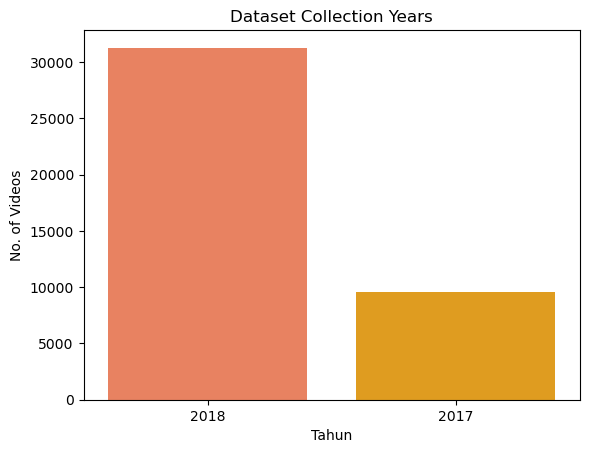

In [22]:
cdf = df['trending_date'].apply(lambda x: '20' + x[:2]).value_counts() \
            .to_frame().reset_index() \
            .rename(columns={'index': 'year', 'trending_date': 'No_of_videos'})

fig, ax = plt.subplots()
_ = sns.barplot(x='year', y='No_of_videos', data=cdf, 
                palette=sns.color_palette(['#ff764a', '#ffa600'], n_colors=7), ax=ax)
_ = ax.set(xlabel='Tahun', ylabel='No. of Videos', title='Dataset Collection Years')

In [23]:
df['trending_date'].apply(lambda x: '20' + x[:2]).value_counts(normalize=True)

2018    0.765179
2017    0.234821
Name: trending_date, dtype: float64

- Dataset dikumpulkan di tahun 2017 dan 2018. 
- Dengan 23% di tahun 2017 dan 77% di tahun 2018. 

In [24]:
# melihat beberapa detail dari 
# statistik deskriptif
display(df.describe(), df.describe(include='object'))

,category_id,views,likes,dislikes,comment_count
count,40878.000000,4.087800e+04,4.087800e+04,4.087800e+04,4.087800e+04
mean,19.975977,2.361074e+06,7.428608e+04,3.712999e+03,8.451877e+03
std,7.563689,7.399534e+06,2.290553e+05,2.905434e+04,3.746156e+04
min,1.000000,5.490000e+02,0.000000e+00,0.000000e+00,0.000000e+00
25%,17.000000,2.419682e+05,5.416250e+03,2.020000e+02,6.130000e+02
50%,24.000000,6.810205e+05,1.806600e+04,6.300000e+02,1.855000e+03
75%,25.000000,1.821942e+06,5.534950e+04,1.935750e+03,5.755000e+03
max,43.000000,2.252119e+08,5.613827e+06,1.674420e+06,1.361580e+06


,category,channel_title,video_id,title,trending_date,publish_time,tags,Description_1,description
count,40878,40878,40878,40878,40878,40878,40878,40878,40878
unique,16,2206,6348,6451,205,6266,6054,2,6898
top,Entertainment,ESPN,j4KvrAUjn6c,Mission: Impossible - Fallout (2018) - Official Trailer - Paramount Pictures,17.14.11,2018-05-18T14:00:04.000Z,[none],With Description,No description
freq,9936,202,29,29,200,50,1520,40311,567


Dari table kita mendapatkan informasi bahwa:
- Rata-rata views yaitu 2.361.074, median yaitu 681.020
- Rata-rata like yaitu 74.286, sedangkan rata-rata dislikes yaitu 3.712
- Rata-rata comment_count yaitu 8.451, median yaitu 1.855
- Terdapat 205 unique trending_date, dimana data kita memiliki data trending video hingga 205 hari. 
- Terdapat 40878 video, akan tetapi terdapat 6451 unique video yang artinya beberapa video muncul di trending video lebih dari 1 hari. 
- Top frequent title yaitu Mission: Impossible - Fallout (2018) - Official Trailer - Paramount Pictures	yang trending selama 29 kali di trending video list.
- Terdapat 6.348 unique video_id akan tetapi untuk berdasarkan title terdapat 6.351 unique title. Saya berasumsi bahwa bisa saja video tersebut ketika muncul di trending list pada hari berikutnya memodifikasi judul videonya. 

In [25]:
# Melakukan pengecekan terkait asumsi saya, apakah ada video yang trending lebih dari 1 hari tapi dengan ttitle yang berbeda
group_video = df.groupby("video_id")
groups = []
wanted_groups = []
for key, item in group_video:
    groups.append(group_video.get_group(key))

for g in groups:
    if len(g['title'].unique()) != 1:
        wanted_groups.append(g)

wanted_groups[0]

,category_id,category,channel_title,video_id,title,trending_date,publish_time,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,tags,Description_1,description
14266,26,Howto & Style,Seth's Bike Hacks,0ufNmUyf2co,Here are the weirdest bikes I own - Freak Bike Check!,18.26.01,2018-01-25T00:00:04.000Z,183149,6969,68,824,False,False,"bikes|""bicycles""|""weird bikes""|""custom bikes""|""fat bike""|""cycling""|""swing bike""|""halfbike""|""bmx bike""|""bmx""|""bike tricks""|""bike stunts""",With Description,"Some of the questions I get most are about my weirdest bikes, so I figured it was time to put together a proper bike check video on them.\n\nIf you're interested in the Swing King, this is the only place you can get it from: https://www.americasbikecompany.com/Swing-King-Swing-Bikes-s/3.htm\n\nAs for the Fat Ripper http://www.sebikes.com/archive/2017/fat-ripper-262\n\nMy Unicycle https://www.unicycle.com/nimbus-27-5-oracle-unicycle/\n\nThe Half bike https://halfbikes.com/\n\nYeah, I know you're going to ask about the Tallgoose too, but that thing is no longer in my possession. I'll check up on it the next time I'm in Miami!\n\nHere are the original videos featuring these bikes\nHalf Bike https://youtu.be/R3NeRXzYmHw\nUnicycle https://www.youtube.com/watch?v=4vOt8THL81s&list=PL5S7V5NhM8JRSJ3bMKsqd3pqQ5wFCwZTT\nFat Ripper https://youtu.be/yO4rexKa_tw\nSwing Bike https://youtu.be/CQyXDd-kPMw\n\nAnd if you're wondering what the Tallgoose is https://youtu.be/qVkaQhiiMP4"
14491,26,Howto & Style,Seth's Bike Hacks,0ufNmUyf2co,Here are the weirdest bikes I own - Freak Bike Check!,18.27.01,2018-01-25T00:00:04.000Z,203919,7358,72,746,False,False,"bikes|""bicycles""|""weird bikes""|""custom bikes""|""fat bike""|""cycling""|""swing bike""|""halfbike""|""bmx bike""|""bmx""|""bike tricks""|""bike stunts""",With Description,"Some of the questions I get most are about my weirdest bikes, so I figured it was time to put together a proper bike check video on them.\n\nIf you're interested in the Swing King, this is the only place you can get it from: https://www.americasbikecompany.com/Swing-King-Swing-Bikes-s/3.htm\n\nAs for the Fat Ripper http://www.sebikes.com/archive/2017/fat-ripper-262\n\nMy Unicycle https://www.unicycle.com/nimbus-27-5-oracle-unicycle/\n\nThe Half bike https://halfbikes.com/\n\nYeah, I know you're going to ask about the Tallgoose too, but that thing is no longer in my possession. I'll check up on it the next time I'm in Miami!\n\nHere are the original videos featuring these bikes\nHalf Bike https://youtu.be/R3NeRXzYmHw\nUnicycle https://www.youtube.com/watch?v=4vOt8THL81s&list=PL5S7V5NhM8JRSJ3bMKsqd3pqQ5wFCwZTT\nFat Ripper https://youtu.be/yO4rexKa_tw\nSwing Bike https://youtu.be/CQyXDd-kPMw\n\nAnd if you're wondering what the Tallgoose is https://youtu.be/qVkaQhiiMP4"
14706,26,Howto & Style,Seth's Bike Hacks,0ufNmUyf2co,Bike Check - My freak bikes,18.28.01,2018-01-25T00:00:04.000Z,216447,7608,74,759,False,False,"bikes|""bicycles""|""weird bikes""|""custom bikes""|""fat bike""|""cycling""|""swing bike""|""halfbike""|""bmx bike""|""bmx""|""bike tricks""|""bike stunts""",With Description,"Some of the questions I get most are about my weirdest bikes, so I figured it was time to put together a proper bike check video on them.\n\nIf you're interested in the Swing King, this is the only place you can get it from: https://www.americasbikecompany.com/Swing-King-Swing-Bikes-s/3.htm\n\nAs for the Fat Ripper http://www.sebikes.com/archive/2017/fat-ripper-262\n\nMy Unicycle https://www.unicycle.com/nimbus-27-5-oracle-unicycle/\n\nThe Half bike https://halfbikes.com/\n\nYeah, I know you're going to ask about the Tallgoose too, but that thing is no longer in my possession. I'll check up on it the next time I'm in Miami!\n\nHere are the original videos featuring these bikes\nHalf Bike https://youtu.be/R3NeRXzYmHw\nUnicycle https://www.youtube.com/watch?v=4vOt8THL81s&list=PL5S7V5NhM8JRSJ3bMKsqd3pqQ5wFCwZTT\nFat Ripper htt

Ternyata memang benar terdapat video yang muncul di trending list menggunakan title yang berbeda dengan title saat pertama kali upload.

**Distribusi Data Views**

c:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


''

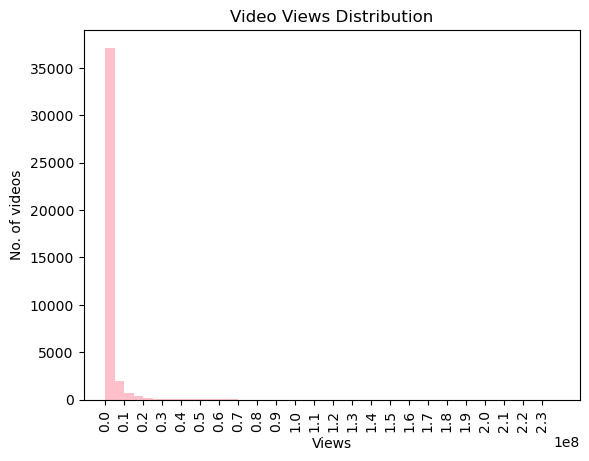

In [26]:
fig, ax = plt.subplots()
_ = sns.distplot(df["views"], kde=False,
                 hist_kws={'alpha': 1}, bins=np.linspace(0, 2.3e8, 47), ax=ax, color='pink')
_ = ax.set(xlabel='Views', ylabel='No. of videos', xticks=np.arange(0, 2.4e8, 1e7), title='Video Views Distribution')
_ = ax.set_xlim(right=2.5e8)
_ = plt.xticks(rotation=90)
;

''

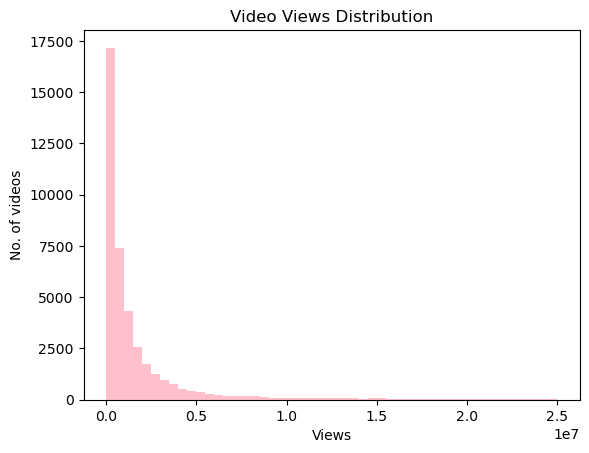

In [27]:
fig, ax = plt.subplots()
_ = sns.distplot(df[df["views"] < 25e6]["views"], kde=False, 
                 color='pink', hist_kws={'alpha': 1}, ax=ax)
_ = ax.set(xlabel='Views', ylabel='No. of videos', title='Video Views Distribution')
;

In [28]:
df[df['views'] < 1e6]['views'].count() / df['views'].count() * 100

60.12769704975781

Dari grafik terlihat bahwa sebagian besar trending video memiliki views sebesar 1 juta views atau kurang. Dengan persentase untuk video dengan views kurang dari 1 juta yaitu 60%. 

**Distribusi Data Likes**

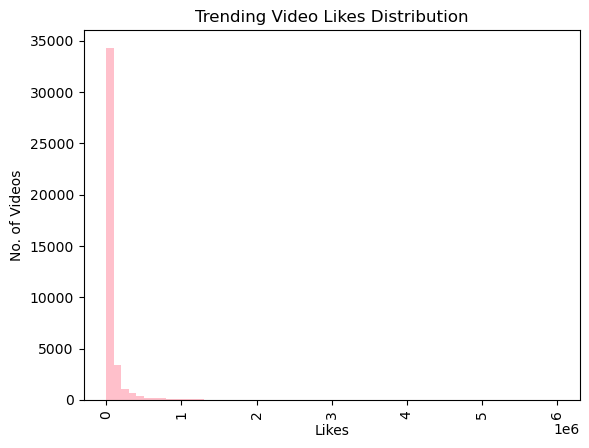

In [29]:
plt.rc('figure.subplot', wspace=0.9)
fig, ax = plt.subplots()
_ = sns.distplot(df["likes"], kde=False, 
                 color='pink', hist_kws={'alpha': 1}, 
                 bins=np.linspace(0, 6e6, 61), ax=ax)
_ = ax.set(xlabel="Likes", ylabel="No. of Videos", title='Trending Video Likes Distribution')
_ = plt.xticks(rotation=90)

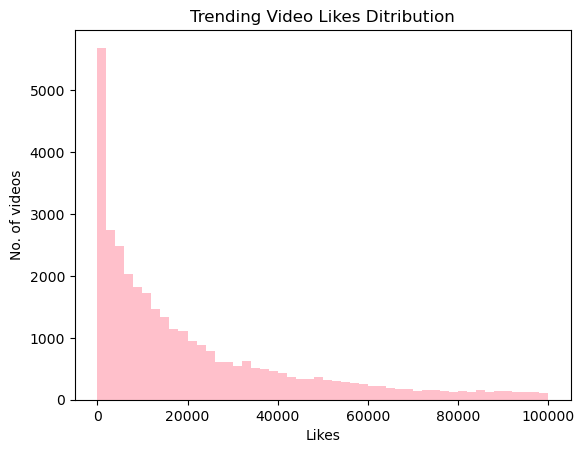

In [30]:
fig, ax = plt.subplots()
_ = sns.distplot(df[df["likes"] <= 1e5]["likes"], kde=False, 
                 color='pink', hist_kws={'alpha': 1}, ax=ax)
_ = ax.set(xlabel="Likes", ylabel="No. of videos", title='Trending Video Likes Ditribution')

In [31]:
df[df['likes'] < 4e4]['likes'].count() / df['likes'].count() * 100

68.51851851851852

Dari grafik terlihat bahwa sebagian besar trending video memiliki likes di rentang 0-40.000. Persentase untuk video kurang dari 40.000 likes yaitu 68.52% 

**Distribusi Data Comment_Count**

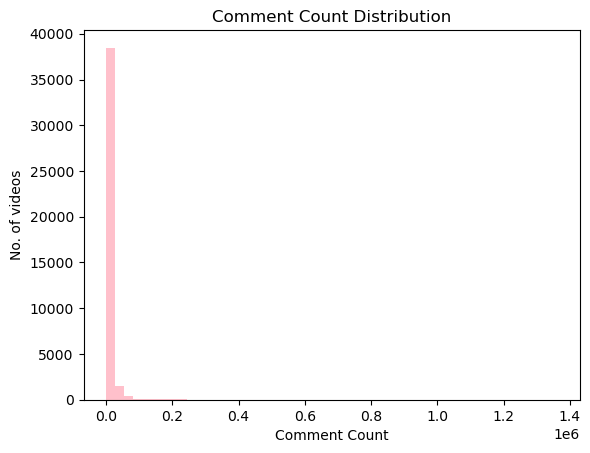

In [32]:
fig, ax = plt.subplots()
_ = sns.distplot(df["comment_count"], kde=False, rug=False, 
                 color='pink', hist_kws={'alpha': 1}, ax=ax)
_ = ax.set(xlabel="Comment Count", ylabel="No. of videos", title='Comment Count Distribution')

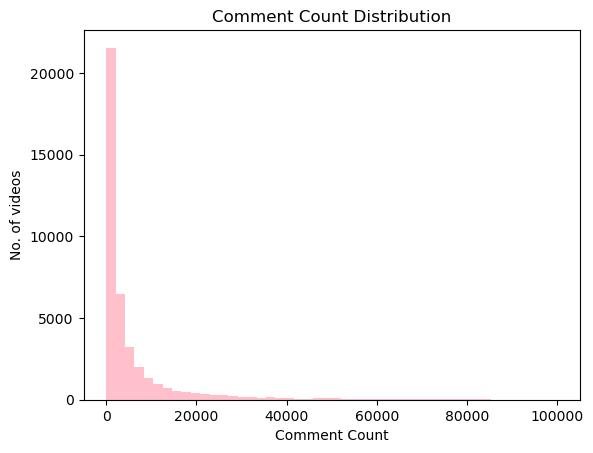

In [33]:
fig, ax = plt.subplots()
_ = sns.distplot(df[df["comment_count"] < 100000]["comment_count"], kde=False, rug=False, 
                 color='pink', hist_kws={'alpha': 1}, 
                 bins=np.linspace(0, 1e5, 49), ax=ax)
_ = ax.set(xlabel="Comment Count", ylabel="No. of videos", title='Comment Count Distribution')

In [34]:
df[df['comment_count'] < 5000]['comment_count'].count() / df['comment_count'].count() * 100

72.26625568765596

Dari grafik terlihat bahwa sebagian besar video memiliki jumlah comment kurang dari 20.000. Dengan persentase video yang memiliki comment kurang dari 5.000 yaitu sebesar 72.26%

In [35]:
# mengubah kolom trending_date ke format datetime
df['trending_date'] = pd.to_datetime(df['trending_date'], format='%y.%d.%m').dt.date

Untuk kolom publish_time terdapat tanggal publish dan waktu publish, saya akan split data ini menjadi kolom baru 

In [36]:
publish_time = pd.to_datetime(df['publish_time'], format='%Y-%m-%dT%H:%M:%S.%fZ')

df['publish_year'] = publish_time.dt.year
df['publish_date'] = publish_time.dt.date
df['publish_time'] = publish_time.dt.time
df['publish_hour'] = publish_time.dt.hour

df = df[['category_id','category','channel_title','video_id','title','publish_year','publish_date','publish_time','publish_hour','trending_date','views','likes','dislikes','comment_count','comments_disabled','ratings_disabled','tags','description','Description_1']]
df.head(1)

,category_id,category,channel_title,video_id,title,publish_year,publish_date,publish_time,publish_hour,trending_date,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,tags,description,Description_1
0,22,People & Blogs,CaseyNeistat,2kyS6SvSYSE,WE WANT TO TALK ABOUT OUR MARRIAGE,2017,2017-11-13,17:13:01,17,2017-11-14,748374,57527,2966,15954,False,False,SHANtell martin,SHANTELL'S CHANNEL - https://www.youtube.com/shantellmartin\nCANDICE - https://www.lovebilly.com\n\nfilmed this video in 4k on this -- http://amzn.to/2sTDnRZ\nwith this lens -- http://amzn.to/2rUJOmD\nbig drone - http://tinyurl.com/h4ft3oy\nOTHER GEAR --- http://amzn.to/2o3GLX5\nSony CAMERA http://amzn.to/2nOBmnv\nOLD CAMERA; http://amzn.to/2o2cQBT\nMAIN LENS; http://amzn.to/2od5gBJ\nBIG SONY CAMERA; http://amzn.to/2nrdJRO\nBIG Canon CAMERA; http://tinyurl.com/jn4q4vz\nBENDY TRIPOD THING; http://tinyurl.com/gw3ylz2\nYOU NEED THIS FOR THE BENDY TRIPOD; http://tinyurl.com/j8mzzua\nWIDE LENS; http://tinyurl.com/jkfcm8t\nMORE EXPENSIVE WIDE LENS; http://tinyurl.com/zrdgtou\nSMALL CAMERA; http://tinyurl.com/hrrzhor\nMICROPHONE; http://tinyurl.com/zefm4jy\nOTHER MICROPHONE; http://tinyurl.com/jxgpj86\nOLD DRONE (cheaper but still great);http://tinyurl.com/zcfmnmd\n\nfollow me; on http://instagram.com/caseyneistat\non https://www.facebook.com/cneistat\non https://twitter.com/CaseyNeistat\n\namazing intro song by https://soundcloud.com/discoteeth\n\nad disclosure. THIS IS NOT AN AD. not selling or promoting anything. but samsung did produce the Shantell Video as a 'GALAXY PROJECT' which is an initiative that enables creators like Shantell and me to make projects we might otherwise not have the opportunity to make. hope that's clear. if not ask in the comments and i'll answer any specifics.,With Description


### Data yang sudah bersih
Setelah selesai membersihkan data, mari lihat kembali data yang telah bersih.

In [37]:
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'unique', 'uniqueSample'],
                     data=listItem)
print(df.shape)
dfDesc

(40878, 19)


,dataFeatures,dataType,null,unique,uniqueSample
0,category_id,int64,0,16,"[20, 19]"
1,category,object,0,16,"[Comedy, Education]"
2,channel_title,object,0,2206,"[Mr Ben Brown, HiHo Kids]"
3,video_id,object,0,6348,"[Xx1tK0RyZxs, v7H_Or9Nr5I]"
4,title,object,0,6451,"[Gabby Barrett Sings The Climb by Miley Cyrus - Top 14 - American Idol 2018 on ABC, New Apple iPad 2018 hands-on]"
5,publish_year,int64,0,12,"[2006, 2016]"
6,publish_date,object,0,313,"[2017-11-08, 2015-03-29]"
7,publish_time,object,0,4476,"[02:19:56, 03:16:36]"
8,publish_hour,int64,0,24,"[13, 3]"
9,trending_date,object,0,205,"[2018-02-04, 2018-03-11]"


In [38]:
# Dilakukan multi indexing agar data lebih terlihat kelompokkannya
multi = list(zip(list(df['category_id']),list(df['category']),list(df['channel_title']),list(df['video_id']),list(df['title']),list(df['publish_year']),list(df['publish_date']),list(df['publish_time']),list(df['publish_hour']),list(df['trending_date'])))
multi_index = pd.MultiIndex.from_tuples(multi)
df_multi = df.set_index(multi_index).drop(columns=['category_id','category','channel_title','video_id','title','publish_year','publish_date','publish_time','publish_hour','trending_date']).sort_index()
df_multi.index.names = ['category_id','category','channel_title','video_id','title','publish_year','publish_date','publish_time','publish_hour','trending_date']

In [39]:
df_multi.drop(columns=['tags','description'])

views  \
category_id category         channel_title    video_id    title                                                               publish_year publish_date publish_time publish_hour trending_date             
1           Film & Animation 20th Century Fox 20bpjtCbCz0 Deadpool 2: The Final Trailer                                       2018         2018-04-19   12:53:52     12           2018-04-21      9823890   
                                                                                                                                                                                  2018-04-22     11861050   
                                                                                                                                                                                  2018-04-23     13310689   
                                                                                                                                                                                  2018-04-24     14365383   
                                                                                                                                                                                  2018-04-25     15175762   
...                                                                                                                                                                                                   ...   
43          Shows            CNET             lM0yu7c6lQk You're not crazy. Apple is slowing down older iPhones. (Apple Byte) 2017         2017-12-22   01:16:16     1            2017-12-29       170686   
                                                                                                                                                                                  2017-12-30       174127   
                                                                                                                                                                                  2017-12-31       176476   
                                                                                                                                                                                  2018-01-01       178191   
                                                                                                                                                                                  2018-01-02       179723   

                                                                                                                                                                                                  likes  \
category_id category         channel_title    video_id    title                                                               publish_year publish_date publish_time publish_hour trending_date           
1           Film & Animation 20th Century Fox 20bpjtCbCz0 Deadpool 2: The Final Trailer                                       2018         2018-04-19   12:53:52     12           2018-04-21     278350   
                                                                                                                                                                                  2018-04-22     308244   
                                                                                                                                                                                  2018-04-23     326373   
                                                                                                                                                                                  2018-04-24     340113   
                                                                                                                                                                                  2018-04-25     349970   
...                                                                                                          

In [40]:
# Saya akan menggunakan data setelah di multi indexing karna sudah lebih tersusun dan lebih enak dilihat 
df = df_multi.reset_index()

In [41]:
df.duplicated(subset=['title']).sum()

34427

In [42]:
#Saya juga akan menggunakan dataframe yang without duplicates video untuk beberapa analisa, 
df_without_duplicate_video = df.drop_duplicates(subset=['title'])

In [43]:
# DataFrame tanpa data tags dan description 
df_without_tagdes = df.drop(columns=['tags','description'])
df_without_tagdes.head(1)

,category_id,category,channel_title,video_id,title,publish_year,publish_date,publish_time,publish_hour,trending_date,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,Description_1
0,1,Film & Animation,20th Century Fox,20bpjtCbCz0,Deadpool 2: The Final Trailer,2018,2018-04-19,12:53:52,12,2018-04-21,9823890,278350,2335,21968,False,False,With Description


In [44]:
# save data ke dalam format csv, untuk digunakan membuat grafik pada tableau
df.to_csv('data capstone 2.csv')

Sebelum dibersihkan, kita memiliki 40.949 baris data dan 17 kolom, sekarang kita memiliki 40.878 baris dan 18 kolom. Ada 71 baris data yang dihapus, dan sisa data kosong diisi dengan data yang dirasa relevan.

## Data Analysis
Setelah selesai melakukan tahap _data cleaning_. Sekarang, akan dilakukan analisis untuk mencari tahu **video dengan topik apa yang paling sering trending** dan **bagaimana karakteristik video youtube agar dapat trending**. 

### Rata-Rata Views, Likes, Dislikes, Comment

In [45]:
avg_views = df_without_duplicate_video['views'].mean()
avg_likes = df_without_duplicate_video['likes'].mean()
avg_dislikes = df_without_duplicate_video['dislikes'].mean()
avg_comment = df_without_duplicate_video['comment_count'].mean()

print(f'Average Views: {avg_views}')
print(f'Average Likes: {avg_likes}')
print(f'Average Dislikes: {avg_dislikes}')
print(f'Average Comment: {avg_comment}')

Average Views: 774338.3782359324
Average Likes: 34477.36040923888
Average Dislikes: 1437.2036893504883
Average Comment: 4489.464114090839


### Kategori Trending Video

Terdapat beberapa kategori pada Youtube. Setiap video memiliki kategorinya sendiri. Kita akan melihat video dengan kategori apa yang paling sering muncul di fitur trending Youtube. 

In [46]:
kategori_video = df.groupby(by='category').agg({'title':['nunique']})
kategori_video.columns= kategori_video.columns.droplevel(1)
kategori_video = kategori_video.reset_index().sort_values(by='title',ascending=False)
kategori_video

,category,title
3,Entertainment,1643
7,Music,821
6,Howto & Style,602
1,Comedy,551
8,News & Politics,513
10,People & Blogs,505
14,Sports,457
12,Science & Technology,391
4,Film & Animation,321
2,Education,257


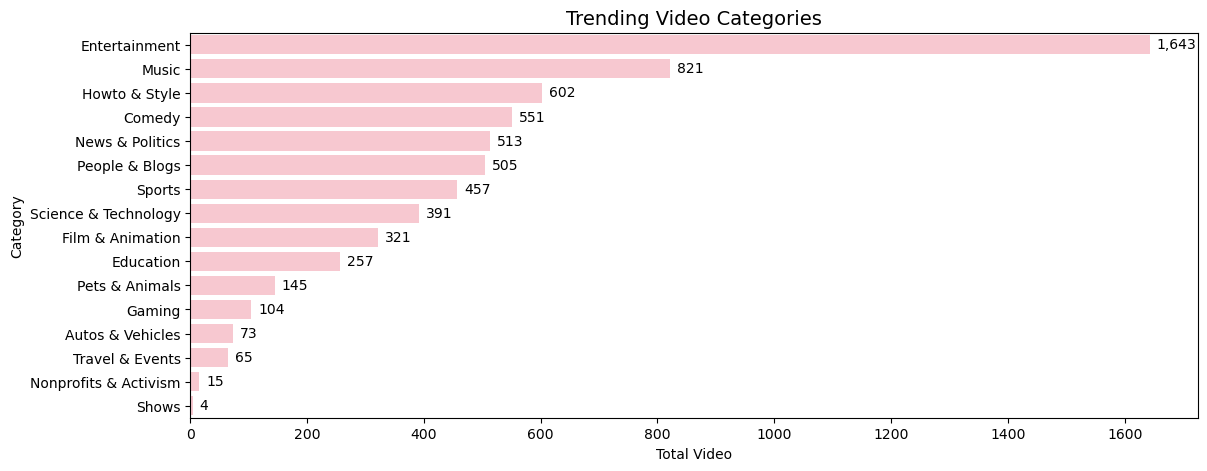

In [47]:
plt.figure(figsize=(13,5))
ax = sns.barplot(
    data=kategori_video,
    x='title',
    y='category',
    ci=0, # kita ga mau lihat confidence interval nya, jadi 0 aja
    color='pink'
)

plt.title('Trending Video Categories', size=14)
container = ax.containers[0]
ax.bar_label(container , labels=[f'{x:,.0f}' for x in container.datavalues], label_type='edge', padding = 5)
plt.xlabel('Total Video')
plt.ylabel('Category')

plt.show()

Insight:
- Kategori yang paling sering trending yaitu video dengan kategori entertainment
- Kategori music merupakan kategori yang sering trending setelah entertainment
- Video dengan kategori shows merupakan kategori yang paling jarang trending di youtube 

### Video Trending Terlama

Terdapat 6451 video pada data. Akan tetapi jumlah baris pada data berjumlah 40.878 baris, sehingga dapat diartikan terdapat beberapa video yang trending lebih dari satu hari.

In [48]:
# melihat video yang trending lebih dari 1 hari
trending_video = df.groupby(by=['category','title','publish_date']).count()[['trending_date']].sort_values(by=['trending_date'], ascending=False).reset_index()
trending_video = trending_video.head(10)
trending_video

,category,title,publish_date,trending_date
0,Entertainment,WE MADE OUR MOM CRY...HER DREAM CAME TRUE!,2018-05-13,29
1,Music,Sam Smith - Pray (Official Video) ft. Logic,2018-05-09,29
2,Film & Animation,Rooster Teeth Animated Adventures - Millie So Serious,2018-05-14,28
3,Film & Animation,Selena Gomez - Back To You (Lyric Video),2018-05-10,28
4,Science & Technology,"The ULTIMATE $30,000 Gaming PC Setup",2018-05-13,28
5,Music,Charlie Puth - BOY [Official Audio],2018-05-11,28
6,Film & Animation,Bohemian Rhapsody | Teaser Trailer [HD] | 20th Century FOX,2018-05-15,28
7,Entertainment,Cobra Kai Season 2,2018-05-10,28
8,Howto & Style,Why I'm So Scared (being myself and crying too much),2018-05-14,28
9,Entertainment,YoungBoy Never Broke Again Goes Sneaker Shopping With Complex,2018-05-14,28


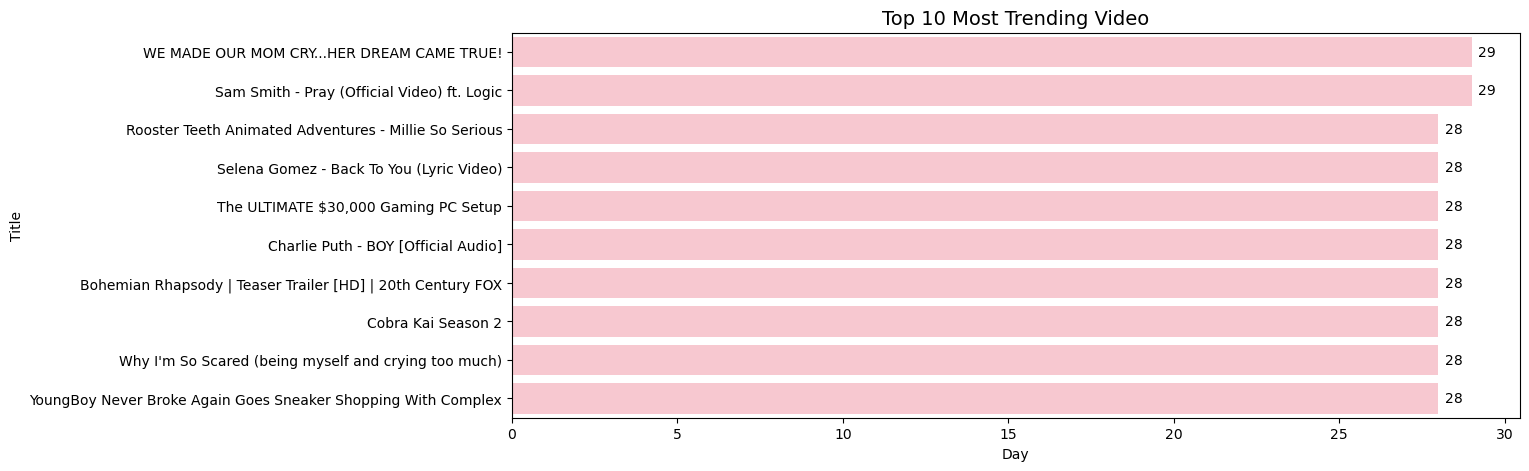

In [49]:
plt.figure(figsize=(13,5))
ax = sns.barplot(
    data=trending_video,
    x='trending_date',
    y='title',
    ci=0, # kita ga mau lihat confidence interval nya, jadi 0 aja
    color='pink'
)

plt.title('Top 10 Most Trending Video', size=14)
container = ax.containers[0]
ax.bar_label(container , labels=[f'{x:,.0f}' for x in container.datavalues], label_type='edge', padding = 5)
plt.xlabel('Day')
plt.ylabel('Title')

plt.show()

Video yang paling banyak trending yaitu:
WE MADE OUR MOM CRY...HER DREAM CAME TRUE! dan Sam Smith - Pray (Official Video) ft. Logic 
Kedua video ini trending selama 29 hari. Top 10 video yang paling banyak trending dapat dilihat pada grafik.

### Channel dengan Views Terbanyak

In [50]:
df_channel = df.groupby(by=['channel_title','title']).tail(1)
df_channel = df_channel.groupby(by='channel_title').sum().sort_values(by='views', ascending=False).reset_index()
df_channel = df_channel.head(10)
df_channel.head(1)

,channel_title,category_id,publish_year,publish_hour,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled
0,ibighit,90,18160,123,271753404,21947654,365906,3400506,0,0


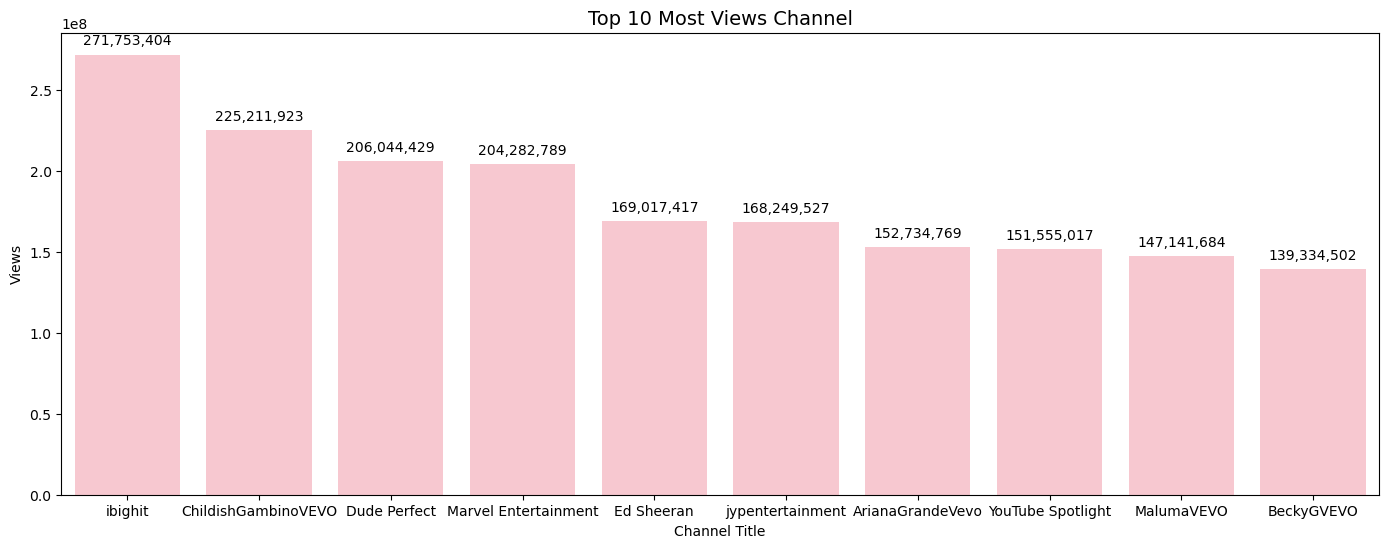

''

In [51]:
plt.figure(figsize=(17,6))
ax = sns.barplot(
    data=df_channel,
    x='channel_title',
    y='views',
    ci=0, # kita ga mau lihat confidence interval nya, jadi 0 aja
    color='pink'
)

plt.title('Top 10 Most Views Channel', size=14)
container = ax.containers[0]
ax.bar_label(container , labels=[f'{x:,.0f}' for x in container.datavalues], label_type='edge', padding = 5)
plt.xlabel('Channel Title')
plt.ylabel('Views')

plt.show()
;

Channnel dengan views yang paling banyak yaitu ibighit dengan 271.753.404 views.

### Tags yang sering digunakan 

In [52]:
# Membuat kolom yang isinya daftar tags
df['tags'] = df['tags'].str.replace("\"","")

kolom_tags = df['tags'].str.split('|',expand=True)
kolom_tags.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68
0,Trailer,Deadpool,20th Century Fox (Production Company),Deadpool Movie,Ryan Reynolds (Celebrity),Ed Skrein (Musical Artist),T. J. Miller (TV Writer),Gina Carano (Martial Artist),Red band,Red band deadpool,Marvel,Marvel Comics,Comic Book (Comic Book Genre),Dead pool,Deadpool green band,Deadpool red band,Action,Comedy,Action Comedy,X-Men (Award-Winning Work),deadpool movie,deadpool sequel,deadpool 2,2nd deadpool movie,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


Kita akan menganalisa daftar yang tags tanpa duplikat, karena jika duplikat artinya tags itu digunakan pada video yang sama. seperti yang kita tahu sebelumnya bahwa terdapat beberapa video yang trending lebih dari 1 hari. sehingga jika ingin menganalisa daftar tags yang sering digunakan agar video trending maka hanya menganalisa dari tags yang digunakan pada 1 video saja tanpa duplikatnya.

In [53]:
# nge drop daftar tags yang digunkan pada video yang sama 
kolom_tags_without_duplicates= kolom_tags.drop_duplicates()
kolom_tags_without_duplicates

kolom_tags_without_duplicates.to_csv('kolom tags.csv', index=False)

In [54]:
# mencari unik dari semua kolom tags
list_kos = []
for i in range(69):
    unik = kolom_tags_without_duplicates[i].unique()
    for j in unik:
        list_kos.append(j)

set_kos = set(list_kos)
list_fix = list(set_kos)

df_test = pd.DataFrame({
    'list':list_fix
})
df_test = df_test.drop(index=0).reset_index().drop(columns='index')
df_test['list'][0]

df_test

,list
0,link fried school lunch taste test
1,SECOND PLACE
2,shrimp
3,Bon
4,best tablet
...,...
56677,housing
56678,Ashok Gadgil
56679,Impression
56680,big little lies


In [55]:
# menghitung berapa kali tags digunakan dari semua tags
d = []
for i in range(len(df_test)):
    jml_kt = (kolom_tags_without_duplicates==df_test['list'][i]).sum().sum()
    d.append(jml_kt)

In [56]:
# menambahkan hasil ke dalam dataframe
df_test.insert(1, 'Jumlah tags', d)
df_test

,list,Jumlah tags
0,link fried school lunch taste test,1
1,SECOND PLACE,1
2,shrimp,3
3,Bon,1
4,best tablet,1
...,...,...
56677,housing,1
56678,Ashok Gadgil,1
56679,Impression,2
56680,big little lies,2


In [57]:
# mengurutkan tags yang paling sering digunakan hingga paling sedikit digunakan 
jumlahtagsss = df_test.sort_values(by='Jumlah tags', ascending=False)
jumlahtagsss

# save data kedalam csv
jumlahtagsss.to_csv('jumlahtagsss.csv', index=False)

In [58]:
# untuk visualisasi diambil 15 tags yang paling sering digunakan
jumlah_tags = jumlahtagsss.head(15)
jumlah_tags

,list,Jumlah tags
15644,funny,589
45291,comedy,519
18663,humor,231
18897,interview,208
38808,music,202
12172,how to,200
22466,2018,193
43845,video,192
33177,news,184
3282,comedian,181


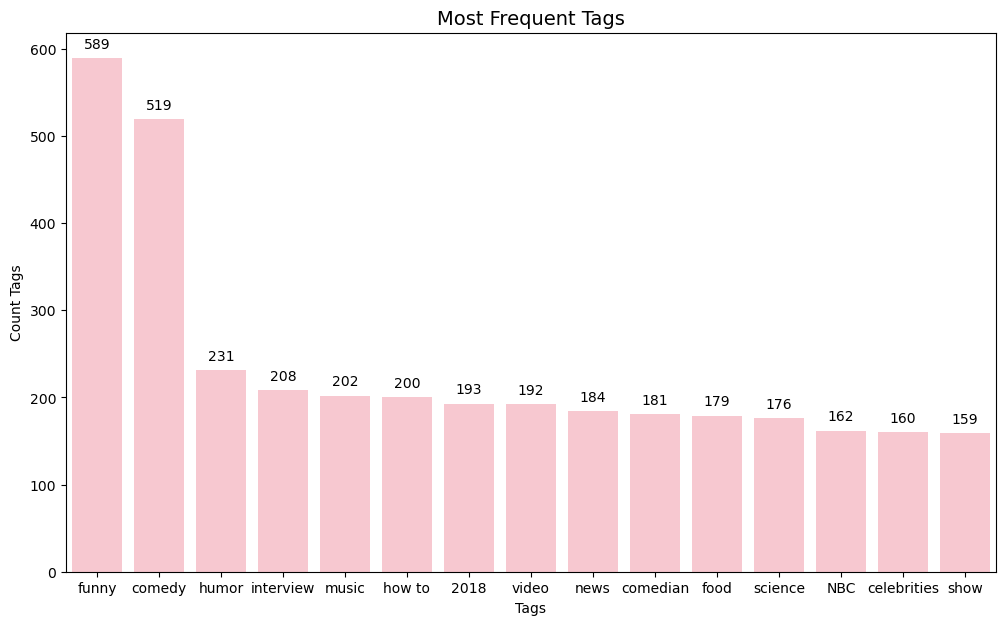

In [59]:
plt.figure(figsize=(12,7))
ax = sns.barplot(
    data=jumlah_tags,
    x='list',
    y='Jumlah tags',
    ci=0, # kita ga mau lihat confidence interval nya, jadi 0 aja
    color='pink'
)

plt.title('Most Frequent Tags', size=14)
container = ax.containers[0]
ax.bar_label(container , labels=[f'{x:,.0f}' for x in container.datavalues], label_type='edge', padding = 5)
plt.xlabel('Tags')
plt.ylabel('Count Tags')

plt.show()

Tags yang paling sering digunakan pada trending video yaitu tag funny sebanyak 589 video diikuti oleh tag comedy sebanyak 519 video. 

### Penggunaan Kapital pada Judul Video

Kita akan melihat berapa banyak judul dari trending video yang setidaknya memiliki 1 kata kapital. Kita akan menambahkan kolom baru pada dataset dengan value yang berisi True or False. True untuk judul yang memiliki setidaknya 1 kata kapital. False untuk lainnya. 

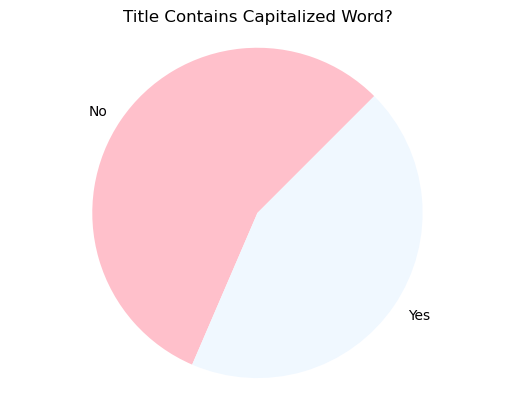

In [60]:
def contains_capitalized_word(s):
    for w in s.split():
        if w.isupper():
            return True
    return False


df['contains_capitalized'] = df['title'].apply(contains_capitalized_word)

value_counts = df["contains_capitalized"].value_counts().to_dict()
fig, ax = plt.subplots()
_ = ax.pie([value_counts[False], value_counts[True]], labels=['No', 'Yes'], 
           colors=['pink', 'aliceblue'], textprops={'color': '#040204'}, startangle=45)
_ = ax.axis('equal')
_ = ax.set_title('Title Contains Capitalized Word?')


In [61]:
df["contains_capitalized"].value_counts(normalize=True)

False    0.560326
True     0.439674
Name: contains_capitalized, dtype: float64

Terdapat 44% dari judul video yang menggunakan setidaknya terdapat 1 kata kapital

### Jumlah Karakter dari Judul Video

c:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


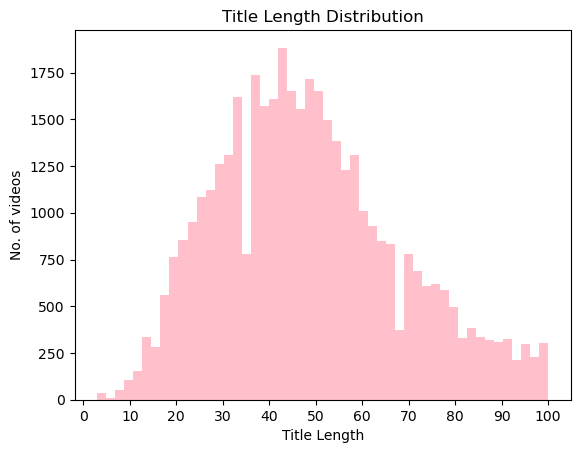

In [62]:
df['title_length'] = df['title'].apply(lambda x: len(x))

fig, ax = plt.subplots()
_ = sns.distplot(df['title_length'], kde=False, rug=False, 
                 color='pink', hist_kws={'alpha': 1}, ax=ax)
_ = ax.set(xlabel='Title Length', ylabel='No. of videos', xticks=range(0, 110, 10), title='Title Length Distribution')

Distribusi dari panjang judul yang digunakan video-video terlihat terdistribusi normal, dimana sebagian besar memiliki panjang karakter antara 30 hingga 60 karakter. 

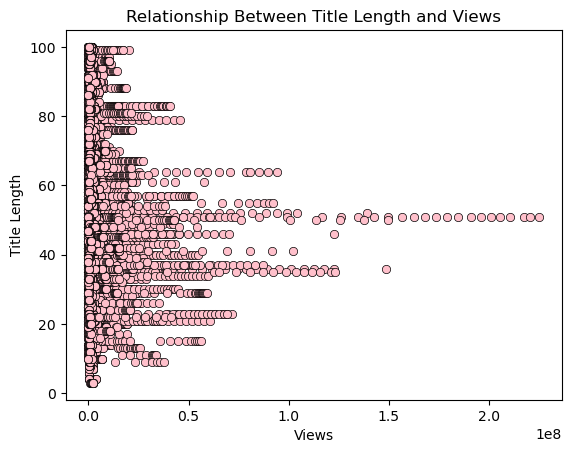

In [63]:
fig, ax = plt.subplots()
_ = ax.scatter(x=df['views'], y=df['title_length'], color='pink', edgecolors="#000000", linewidths=0.5)
_ = ax.set(xlabel='Views', ylabel='Title Length', title='Relationship Between Title Length and Views')

Dari grafik terlihat bahwa tidak ada hubungan antara panjang title dengan views, akan tetapi ada hal menarik yang kita dapatkan dari grafik diatas yaitu video yang memiliki views 100.000.000 atau lebih menggunakan judul dengan panjang kata antara 40 hingga 60 karakter. 

### Kata yang sering digunakan pada judul

Apakah ada kata-kata yang sering digunakan di judul video-video trending ini?

In [64]:
title_words = list(df['title'].apply(lambda x: x.split()))
title_words = [x for y in title_words for x in y]
a = Counter(title_words).most_common(25)
word_title = pd.DataFrame({
    'Kata': [item[0] for item in a],
    'Jumlah': [item[1] for item in a],
})
word_title = word_title.drop(index=range(0,12))
word_title.to_csv('jumlah word.csv')

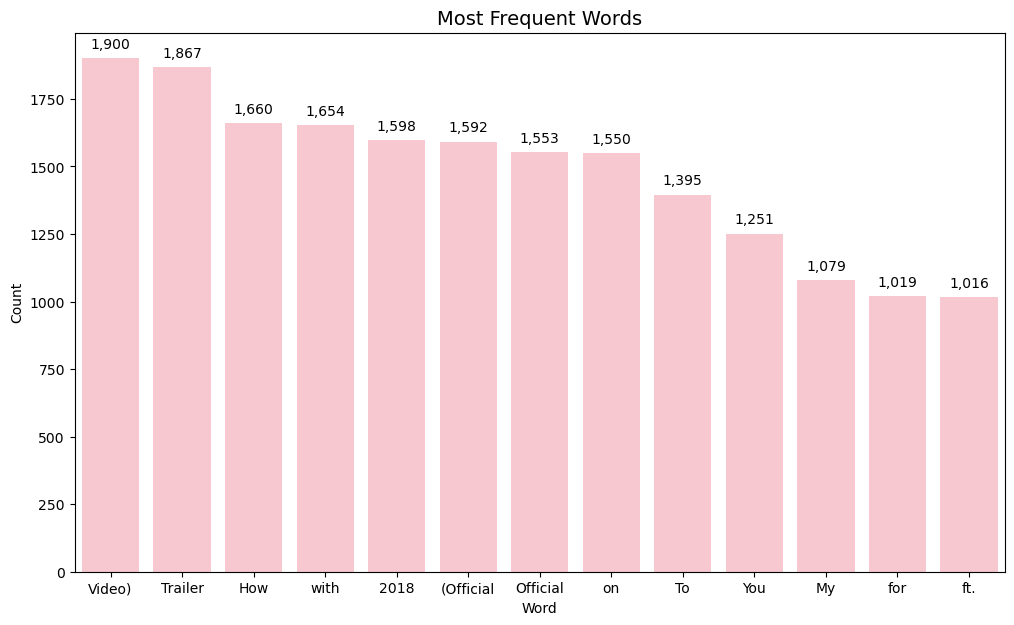

In [65]:
plt.figure(figsize=(12,7))
ax = sns.barplot(
    data= word_title,
    x='Kata',
    y='Jumlah',
    ci=0, # kita ga mau lihat confidence interval nya, jadi 0 aja
    color='pink'
)

plt.title('Most Frequent Words', size=14)
container = ax.containers[0]
ax.bar_label(container , labels=[f'{x:,.0f}' for x in container.datavalues], label_type='edge', padding = 5)
plt.xlabel('Word')
plt.ylabel('Count')

plt.show()

Dengan mengabaikan kata kata seperti 'the','of', dan beberapa simbol seperti '-','|'. Didapatkan kata-kata yang sering digunakan pada judul video Youtube yaitu kata-kata 'video','trailer','how','2018','official'. Terdapat 1553-1900 video per masing-masingnya yang menggunaan kata tersebut.

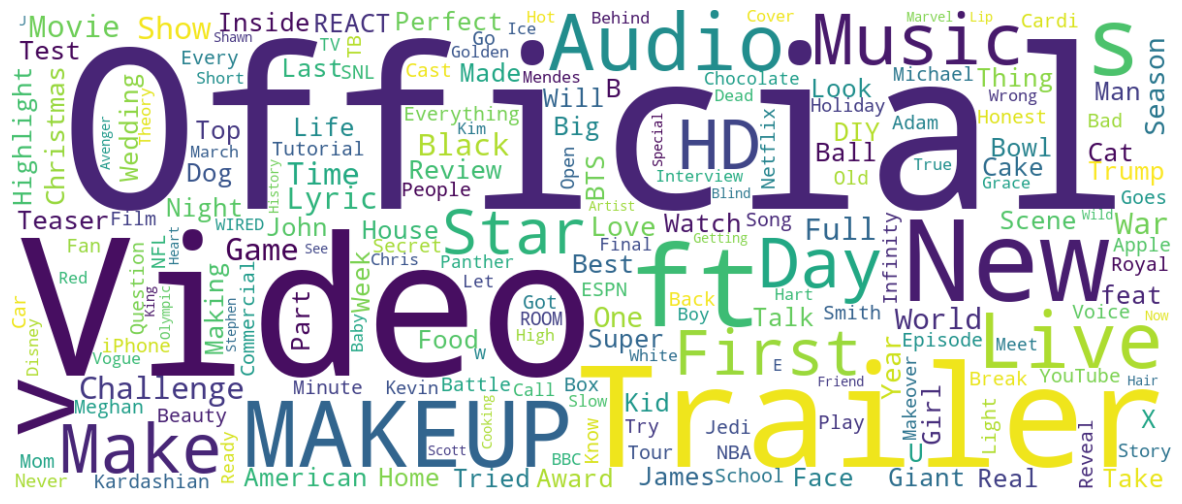

In [66]:
wc = wordcloud.WordCloud(width=1200, height=500, 
                         collocations=False, background_color="white", 
                         ).generate(" ".join(title_words))
plt.figure(figsize=(15,10))
plt.imshow(wc, interpolation='bilinear')
_ = plt.axis("off")

### Korelasi antara variable-variable dataset

Korelasi direpresentasikan sebagai nilai antara -1 dan +1 dimana +1 merupakan korelasi positif kuat, -1 menunjukkan variabel berkorelasi negatif kuat, 0 menunjukkan bahwa tidak ada korelasi.  

<AxesSubplot:>

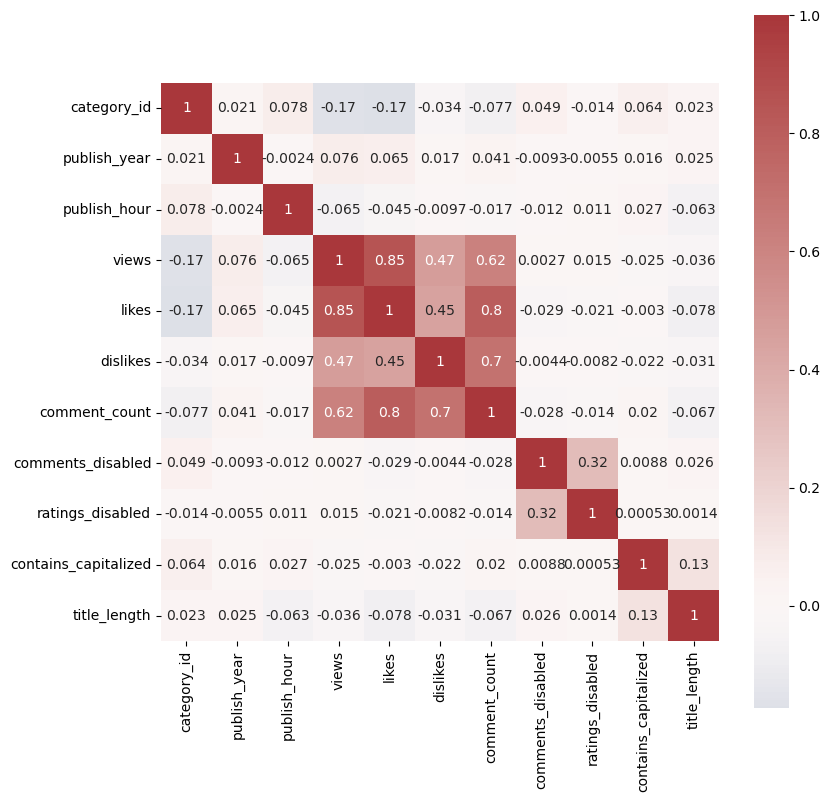

In [67]:

plt.figure(figsize=(9,9))

sns.heatmap(data=df.corr(), annot=True, cmap='vlag', center=0, square=True)

- Dari heatmap dapat terlihat bahwa views dan likes berkorelasi positif dan sangat kuat dengan nilai 0.85. 
- Variable likes dan comment_count juga miliki korelasi positif yang kuat dengan nilai 0.8
- korelasi antara dislikes dan comment_count yaitu 0.7

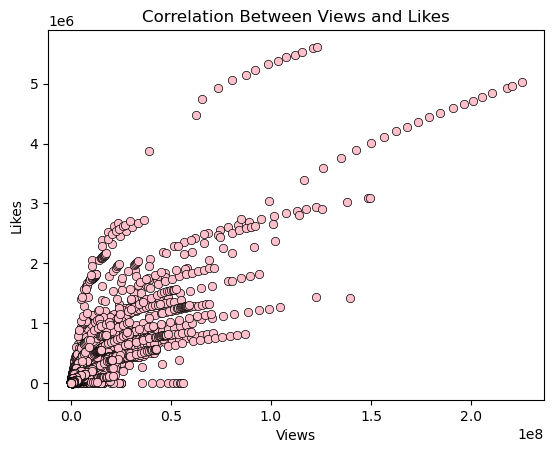

In [68]:
# melihat apakah korelasinya benar kuat positif
fig, ax = plt.subplots()
_ = plt.scatter(x=df['views'], y=df['likes'], color='pink', edgecolors="#000000", linewidths=0.5)
_ = ax.set(xlabel='Views', ylabel='Likes', title='Correlation Between Views and Likes')

Dari grafik terlihat bahwa views dan likes benar berkorelasi positif dan kuat dimana saat views nya naik maka jumlah likenya juga akan naik (mostly). 

### Waktu yang paling tepat untuk upload video

In [69]:
df_without_duplicate_video.median()

C:\Users\user\AppData\Local\Temp\ipykernel_10748\1629821973.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_without_duplicate_video.median()


category_id              24.0
publish_year           2018.0
publish_hour             15.0
views                275075.0
likes                  8011.0
dislikes                245.0
comment_count           922.0
comments_disabled         0.0
ratings_disabled          0.0
dtype: float64

Waktu yang palng tepat untuk upload video yaitu pukul 15 dilihat dari nilai tengah rata-rata trending video yang ada.

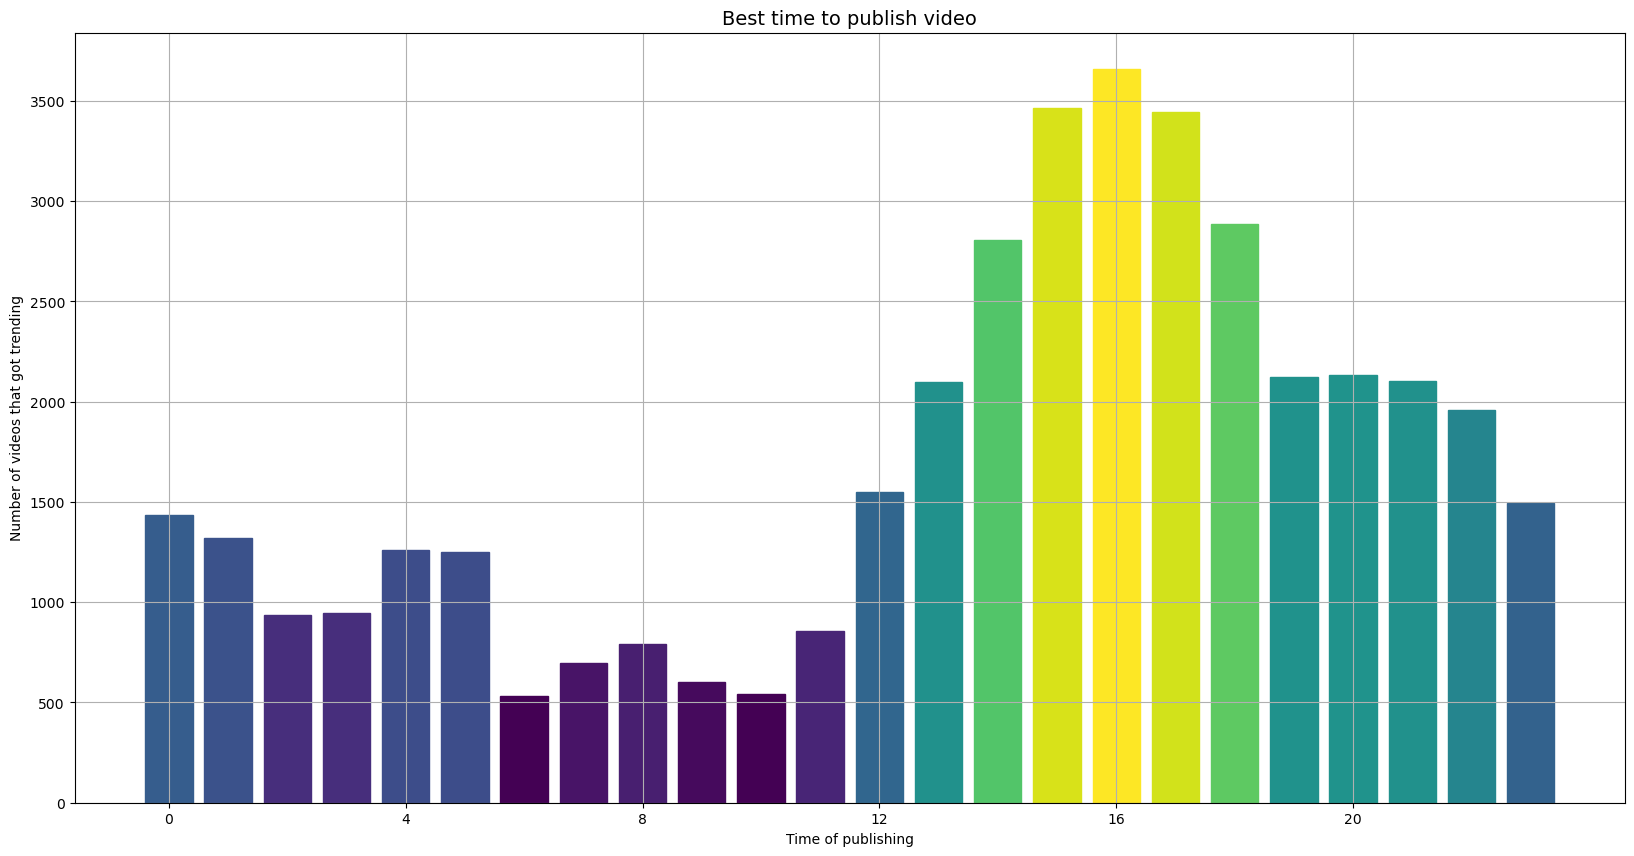

In [70]:
# Initialization of the list storing counters for subsequent publication hours
publish_h = [0] * 24

for index, row in df.iterrows():
    publish_h[row["publish_hour"]] += 1
    
values = publish_h
ind = np.arange(len(values))


# Creating new plot
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.yaxis.grid()
ax.xaxis.grid()
bars = ax.bar(ind, values)


# Sampling of Colormap
for i, b in enumerate(bars):
    b.set_color(plt.cm.viridis((values[i] - min(values))/(max(values)- min(values))))
    
plt.ylabel('Number of videos that got trending')
plt.xlabel('Time of publishing')
plt.title('Best time to publish video', fontsize=14)
plt.xticks(np.arange(0, len(ind), len(ind)/6), [0, 4, 8, 12, 16, 20])

plt.show()

# Kesimpulan

Dari analisa yang telah dilakukan, didapatkan kesimpulan bahwa beberapa karakteristik dari video trending yaitu 

- Untuk kategori yang sering trending yaitu entertainment, diikuti music, howto and style, comedy, news and politics.
- Hashtags yang sering digunakan untuk video trending yaitu funny sebanyak 589, setelah itu comedy, humor, interview, music.
- Panjang karakter untuk judul sebuah video trending yang  memiliki views 100.000.000 atau lebih menggunakan judul dengan panjang karakter antara 40 hingga 60 karakter. 
- Kata yang paling sering digunakan pada judul yaitu video sebanyak 1900, setelah itu trailer, how
- Waktu terbaik untuk upload video yaitu pada rentang pukul 15.00-17.00.

# Actionable Recommendations

Berdasarkan analisis yang telah dilakukan, jika ingin memilih video-video mana saja yang akan dijadikan untuk penempatan iklan, 
maka bisa dilihat dari:
- video yang memiliki panjang karakter 40 hingga 60 karakter karna memiliki potensi yang cukup besar untuk mendapatkan views lebih dari 100.000.000 
- memilih video-video dari kategori entertainment dan music 
- video yang memiliki tags funny, humor juga dapat dijadikan bahan pertimbangan
- video yang di post pada rentang jam 15.00-17.00 